# Simple California Demo



This notebook shows how to use build a hierarchical clustering of the input features and use it to explain a single instance. This is a good way to explain a single instance when the number of input features is large.
When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

In [2]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.0 MB/s eta 0:00:00m eta 0:00:01m0:00:01


In [3]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor

import shap

seed = 2023
np.random.seed(seed)

## Train a model

In [4]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

## Compute a hierarchical clustering of the input features

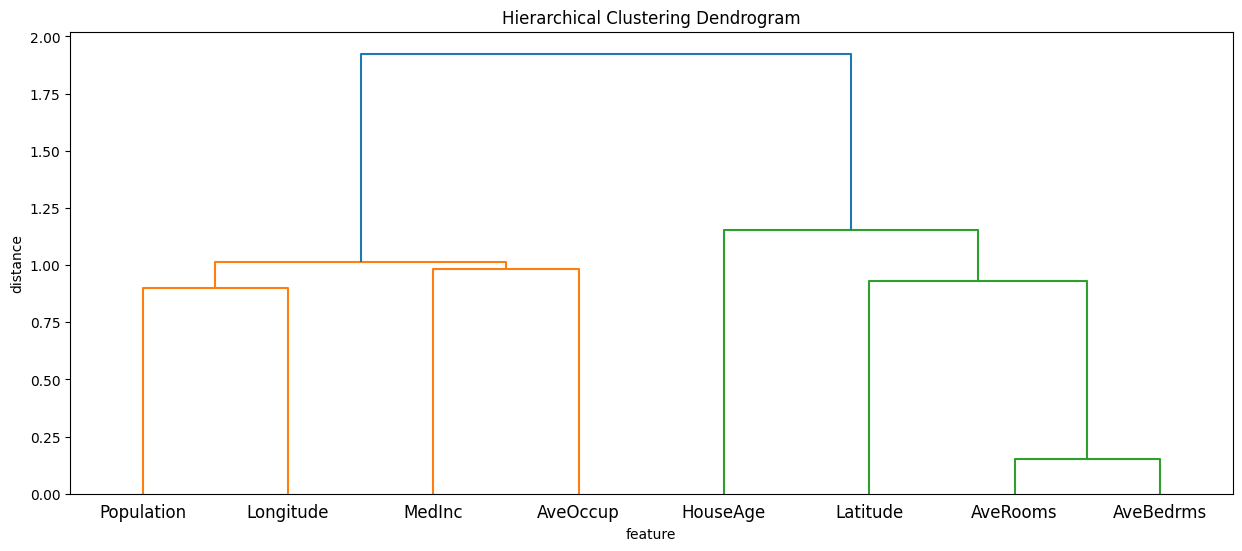

In [5]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

## Explain the instance

In [6]:
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=partition_tree)

# build explainer objects
raw_explainer = shap.PartitionExplainer(model.predict, X)
masker_explainer = shap.PartitionExplainer(model.predict, masker)

# compute SHAP values
raw_shap_values = raw_explainer(instance)
masker_shap_values = masker_explainer(instance)

In [7]:
# comparison the masker and the original data sizes
print(f"X size: {sys.getsizeof(X)/1024:.2f} kB")
print(f"masker size: {sys.getsizeof(masker)} B")

X size: 1290.14 kB
masker size: 48 B


## Compare to Tree SHAP

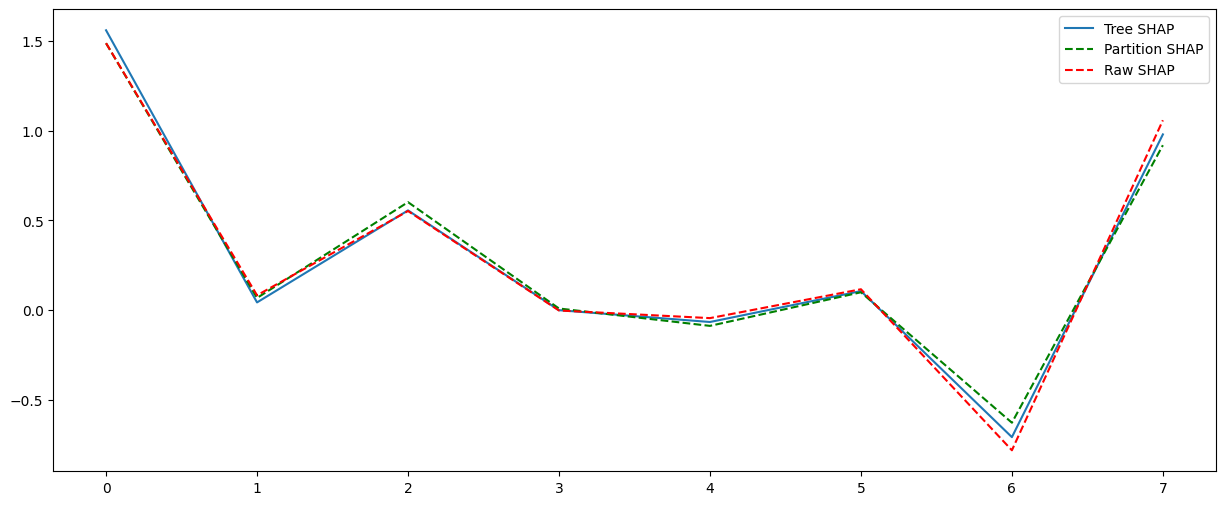

In [8]:
tree_explainer = shap.TreeExplainer(model, X)
tree_shap_values = tree_explainer(instance)

plt.figure(figsize=(15, 6))
plt.plot(tree_shap_values[0].values, label="Tree SHAP")
plt.plot(masker_shap_values[0].values, "g--", label="Partition SHAP")
plt.plot(raw_shap_values[0].values, "r--", label="Raw SHAP")

plt.legend()
plt.show()

Partition SHAP values using a partition tree are nice estimation of SHAP values. The partition tree is a good way to reduce the number of input features and speed up the computation.

## Plots to explain the instance

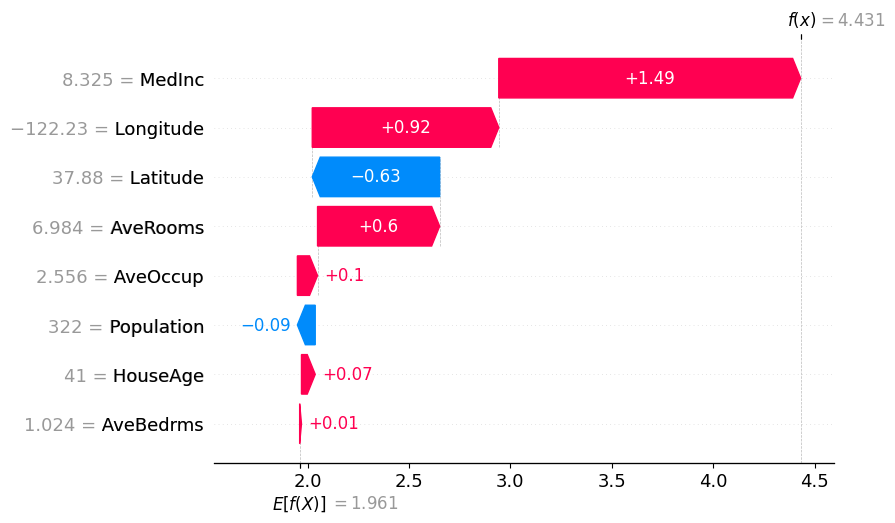

In [9]:
shap.plots.waterfall(masker_shap_values[0])